# Tagger impact on sentiment cattegories classification

In [1]:
import re
import operator
from functools import reduce
import requests
import http.client
import json
from sklearn.feature_extraction.text import CountVectorizer
from enum import Enum
import xml.etree.ElementTree as ET
import pandas as pd
import ast
from tqdm import tqdm_notebook as tqdm
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import time
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Grupowanie klas gramatycznych NKJP do części mowy

Poniżej przedstawiono kod, który wykorzystano przy filtrowaniu wyjścia z taggera do części mowy. Korzytano z taggerów sieciowych, do których wysyłano teksty z kolejnych wzorców etykietowanych korpusu. Nastepnie przetwarznao wyjście z formatu XML do listy par o postaci [('wyraz',<forma gramatyczna>), ...]. Przetworzone wyjście wraz z etytkietą zapisywano do pliku. UWAGA kod obsługujący taggery znajduje się w pliku Taggers !

In [ ]:
class PartOfSpeech(Enum):
    RZECZOWNIK = 1
    CZASOWNIK = 2
    PRZYMIOTNIK = 3
    LICZEBNIK = 4
    ZAIMEK = 5
    PRZYIMEK = 6
    PRZYSŁÓWEK = 7
    PARTYKUŁA = 8
    WYKRZYKNIK = 9
    SPÓJNIK = 10
    SKRÓT = 11
    OTHER = 12
    
def get_part_of_speech(tagger_result):
    part_shortcut = tagger_result.split(':')[0]
    
    if part_shortcut in ['subst', 'depr']:
        return PartOfSpeech.RZECZOWNIK
    elif part_shortcut in ['numcol', 'num']:
        return PartOfSpeech.LICZEBNIK
    elif part_shortcut in ['adj', 'adja', 'adjp', 'adjc']:
        return PartOfSpeech.PRZYMIOTNIK
    elif part_shortcut in ['adv', 'qub']:
        return PartOfSpeech.PRZYSŁÓWEK
    elif part_shortcut in ['ppron12', 'ppron3', 'siebie']:
        return PartOfSpeech.ZAIMEK
    elif part_shortcut in ['fin', 'bedzie', 'aglt', 'praet', 'impt', 'imps', 'inf', 'pcon', 'pant', 
                           'ger', 'pact', 'ppas', 'winien']:
        return PartOfSpeech.CZASOWNIK
    elif part_shortcut in ['prep']:
        return PartOfSpeech.PRZYIMEK
    elif part_shortcut in ['conj', 'comp']:
        return PartOfSpeech.SPÓJNIK
    elif part_shortcut in ['brev']:
        return PartOfSpeech.SKRÓT
    elif part_shortcut in ['interjection']:
        return PartOfSpeech.WYKRZYKNIK
    elif part_shortcut in ['burk', 'interp', 'xxx', 'ign','pred']:
        return PartOfSpeech.OTHER
    else:
        print('part_shortcut = ' + part_shortcut + ' NOT FOUND!!!')
        
def filter_nouns(tagger_output):
    nouns=[]
    for base,form in tagger_output:
        if get_part_of_speech(form)==PartOfSpeech.RZECZOWNIK:
            nouns.append(base)
    return nouns

def filter_adjectives(tagger_output):
    nouns=[]
    for base,form in tagger_output:
        if get_part_of_speech(form)==PartOfSpeech.PRZYMIOTNIK:
            nouns.append(base)
    return nouns

def filter_verbs(tagger_output):
    nouns=[]
    for base,form in tagger_output:
        if get_part_of_speech(form)==PartOfSpeech.CZASOWNIK:
            nouns.append(base)
    return nouns

#### Uzasadnienie rozpozanwania części mowy 

Części mowy rozpoznawno na podstawie dokumentacji oraz oberwacji w wynikach zwracanch przez taggery. Poniżej przedstawiono listę klas gramatycznych mapowanych do rzeczowników, czasowników i przymiotników wraz z przykłądami otrzymanymi na wyjściu z taggera.

#### Przykłady w wynikach z taggera

    Rzeczowniki:
- subst: wykład
- depr: wejściowki

    Przymiotniki:
    
- adj:internetowy
- adja: ziołowo
- adjc:pełny 
- adjp:prosty

    Czasowniki:
    
- fin:musieć
- aglt:być
- praet:mieć
- impt: powiedzieć
- imps:zadzwonić
- inf:podliczyć
- pcon:różnić
- pant: zważyć
- ger:wejść
- pact:pić
- ppas:polecać

### Wczytanie i przygotowanie danych do klasyfikacji

##### Metodologia
    
Po otagowaniu korpusu wybranym taggerem, wykorzystując powyzej zdefiniowane metody indetyfikacji części mowy, ofiltrowwywano czasowniki, rzeczowniki i przymiotniki, a następnie, korzystają z pakietu scikit-learn, tworzono model Bags of Words oraz wektoryzowano poszczególne wtykietowane teksty. Wyniki zapisywano do plików. Na koniec tworzono róznież dla każdego testu cechy połączone - dotyczące zarówno czasowników, rzeczowników, jak i przymiotników. 

In [178]:
TAGGERS=['wcrf_morf1','morphodita','ml','wcrf2_morf2','krnnt']
SPEECH_PARTS=['verbs','nouns','adj','all']

In [179]:
LABELS=['meta_minus_m','meta_minus_s','meta_plus_m','meta_plus_s','meta_amb','meta_zero']

In [180]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [181]:
def merge_all_features(tagger):
    x_1=np.load('features/'+tagger+'/x_verbs.npy')
    x_2=np.load('features/'+tagger+'/x_nouns.npy')
    x_3=np.load('features/'+tagger+'/x_adj.npy')
    result=np.append(x_1,x_2,axis=1)
    result2=np.append(result,x_3,axis=1)
    np.save('features/'+tagger+'/x_all.npy',result2)

In [182]:
def prepare_data(taggger,speech_part,train_to_test_ratio):
    x,y=np.load('features/'+taggger+'/x_'+speech_part+'.npy'),np.load('features/'+taggger+'/y_'+speech_part+'.npy')
    x,y=unison_shuffled_copies(x,y)
    limit=int(train_to_test_ratio*x.shape[0])
    x_train,x_test=x[0:limit],x[limit:]
    y_train,y_test=y[0:limit].transpose()[0],y[limit:].transpose()[0]
    
    tf_transformer = TfidfTransformer(use_idf=False).fit(x_train)
    x_train_tf = tf_transformer.transform(x_train)
    x_test_tf=tf_transformer.fit_transform(x_test)

    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train)
    x_test_tfidf=tfidf_transformer.fit_transform(x_test)
    
    return x_train,x_train_tf,x_train_tfidf,y_train,x_test,x_test_tf,x_test_tfidf,y_test

In [183]:
X_train,X_train_tf,X_train_tfidf,Y_train,X_test,X_test_tf,X_test_tfidf,Y_test=prepare_data('krnnt','verbs',0.8)

In [184]:
X_train.shape

(7459, 8491)

In [185]:
tf_transformer = TfidfTransformer(use_idf=False)

In [186]:
tfidf_transformer = TfidfTransformer()

### Klasyfikacja - Multinomial Bayes, SVN

##### Metdodologia 
Jako klsyfikatory wzięto pod uwagę klasyfikator MultinomialBayes oraz klasyfikator SVN optmalizowany przez SGD. 
Dokonywano klasyfikacji bezpoścrednio na postaci zwektoryzowanej, jak również po zamianie cech na częśtotliwości metodą TF(term frequency) i TFIDF (inverse document frequency)

In [187]:
def multinomial_bayes_classifier(x_train,y_train):
    x_train_tf = tf_transformer.transform(x_train)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train)
    clf1 = MultinomialNB().fit(x_train,y_train)
    clf2 = MultinomialNB().fit(x_train_tf,y_train)
    clf3 = MultinomialNB().fit(x_train_tfidf,y_train)
    return clf1,clf2,clf3

def SVN_classifier(x_train,y_train):
    x_train_tf = tf_transformer.transform(x_train)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train)
    clf1=SGDClassifier(loss='hinge', penalty='l2',
                          alpha=0.005, random_state=42,
                          max_iter=30, tol=None).fit(x_train,y_train)
    clf2=SGDClassifier(loss='hinge', penalty='l2',
                              alpha=0.005, random_state=42,
                              max_iter=30, tol=None).fit(x_train_tf,y_train)
    clf3=SGDClassifier(loss='hinge', penalty='l2',
                              alpha=0.005, random_state=42,
                              max_iter=30, tol=None).fit(x_train_tfidf,y_train)
    return clf1,clf2,clf3

def MLP_classifier(x_train,y_train):
    x_train_tf = tf_transformer.transform(x_train)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train)
    clf1=MLPClassifier(max_iter=40,verbose=False).fit(x_train,y_train)
    clf2=MLPClassifier(max_iter=40,verbose=False).fit(x_train_tf,y_train)
    clf3=MLPClassifier(max_iter=40,verbose=False).fit(x_train_tfidf,y_train)
    return clf1,clf2,clf3
    

def evaluate_acc(x_test,y_test,clf1,clf2,clf3): 
    x_test_tf = tf_transformer.transform(x_test)
    x_test_tfidf = tfidf_transformer.fit_transform(x_test)
    predicted1 = clf1.predict(x_test)
    predicted2 = clf2.predict(x_test_tf)
    predicted3 = clf3.predict(x_test_tfidf)
    ac1=accuracy_score(y_test, predicted1)
    ac2=accuracy_score(y_test, predicted2)
    ac3=accuracy_score(y_test, predicted3)
    return ac1,ac2,ac3

def evaluate_f1(x_test,y_test,clf1,clf2,clf3): 
    x_test_tf = tf_transformer.transform(x_test)
    x_test_tfidf = tfidf_transformer.fit_transform(x_test)
    predicted1 = clf1.predict(x_test)
    predicted2 = clf2.predict(x_test_tf)
    predicted3 = clf3.predict(x_test_tfidf)
    f1=f1_score(y_test, predicted1,average='micro')
    f2=f1_score(y_test, predicted2,average='micro')
    f3=f1_score(y_test, predicted3,average='micro')
    return f1,f2,f3

In [188]:
c1,c2,c3=multinomial_bayes_classifier(X_train,Y_train)
print(evaluate_acc(X_test,Y_test,c1,c2,c3))

(0.6386058981233244, 0.524396782841823, 0.5919571045576407)


### Tworzenie statystyk

In [189]:
def create_statistics(file_name):
    TAGGERS=['wcrf_morf1','morphodita','ml','wcrf2_morf2','krnnt']
    SPEECH_PARTS=['verbs','nouns','adj','all']
    
    CLASSIFIERS=['NAIVE BAYES', 'SVN']
    
    RATIOS=[0.6,0.7,0.8,0.9]

    COLS=['TAGGER','SPEECH_PART','CLASSIFIER','RATIO','ACC', 'TF_ACC', 'TF2_ACC', 'F1','TF_F1', 'TF2_F1']
    df = pd.DataFrame(columns=COLS)
    df.to_csv(file_name + '.csv',index=False)
    for tagger in TAGGERS:
        for speech_part in SPEECH_PARTS:
            for ratio in RATIOS:
                X_train,X_train_tf,X_train_tfidf,Y_train,X_test,X_test_tf,X_test_tfidf,Y_test=prepare_data(tagger,speech_part,ratio)
                for classifier in CLASSIFIERS:
                    classifier_func=multinomial_bayes_classifier
                    if classifier == 'SVN':
                        classifier_func=SVN_classifier
                    clf1,clf2,clf3=classifier_func(X_train,Y_train)
                    ac1,ac2,ac3=evaluate_acc(X_test,Y_test,clf1,clf2,clf3)
                    f1,f2,f3=evaluate_f1(X_test,Y_test,clf1,clf2,clf3)
                    zipped=zip([tagger],[speech_part],[classifier],[ratio],[ac1],[ac2],[ac3],[f1],[f2],[f3])
                    pd.DataFrame(zipped,columns=COLS).to_csv(file_name + '.csv', mode='a', header=False, index=False)

In [190]:
# create_statistics('statistics')

## Badania

Na zboirach treningowych zdefiniowanych jak powyżej oraz z wykjorzystaniem klasyfikatorów Naive Bayes oraz SVN wykonywano badania miary accuracy oraz F-score w zależności od: 
  - taggera
  - klsyfikatora
  - części mowy( czasowniki, przymiotniki, rzeczowniki, wszystkie części mowy
  - stosunku podziału zbioru treningowego do testowego

Wyniki przedstawiono poniżej. 
  
    

### Wizualizacje

In [3]:
stats=pd.read_csv('statistics.csv').sort_values(by=['ACC'],ascending=False)

In [193]:
stats

,TAGGER,SPEECH_PART,CLASSIFIER,RATIO,ACC,TF_ACC,TF2_ACC,F1,TF_F1,TF2_F1
157,krnnt,all,SVN,0.8,0.721716,0.664343,0.697587,0.721716,0.664343,0.697587
155,krnnt,all,SVN,0.7,0.715868,0.672266,0.697999,0.715868,0.672266,0.697999
127,wcrf2_morf2,all,SVN,0.9,0.713489,0.678930,0.687848,0.713489,0.678930,0.687848
125,wcrf2_morf2,all,SVN,0.8,0.713330,0.664250,0.679866,0.713330,0.664250,0.679866
121,wcrf2_morf2,all,SVN,0.6,0.705521,0.663134,0.694367,0.705521,0.663134,0.694367
...,...,...,...,...,...,...,...,...,...,...
0,wcrf_morf1,verbs,NAIVE BAYES,0.6,0.441758,0.419780,0.425824,0.441758,0.419780,0.425824
5,wcrf_morf1,verbs,SVN,0.8,0.435714,0.445604,0.448901,0.435714,0.445604,0.448901
1,wcrf_morf1,verbs,SVN,0.6,0.430495,0.426099,0.433242,0.430495,0.426099,0.433242
7,wcrf_morf1,verbs,SVN,0.9,0.429670,0.436264,0.448352,0.429670,0.436264,0.448352


Najlepsze wyniki osiągnięto dla taggera krnnt przy stosunku train/test=0.8, klasyfikatorze SVN i wszystkich częściach mowy branych pod uwagę. Miara accuracy wyniosła 72.2 %

#### Wpływ doboru taggera na klasyfikację cześci mowy

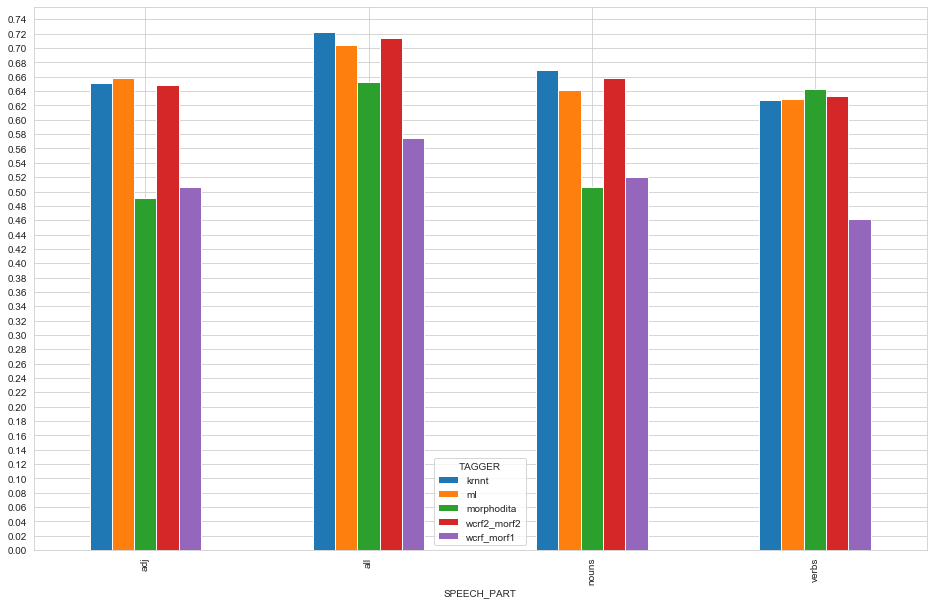

In [194]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax.set_ylim(bottom=50,top=75)
stats.groupby(['SPEECH_PART','TAGGER']).max()['ACC'].unstack().plot.bar(ax=ax)

    Na przymiotnikach najlepiej radził sobie tagger ml, konkurencyjnie z krnnt i wcr2. 
    Czasowniki najlepiej klasyfikował tagger morphodita.
    Rzeczowniki - najlepiej krnnt i wcrf2 z morfeuszem2.
    Biroąc pod uwagę wszystkie części mowy najlepsze okazały się tagery : krnnt, wcrf_morf2 i ml.

#### Wpływ wyboru cześci mowy na wyniki klasyfikacji przy użyciu różnych taggerów

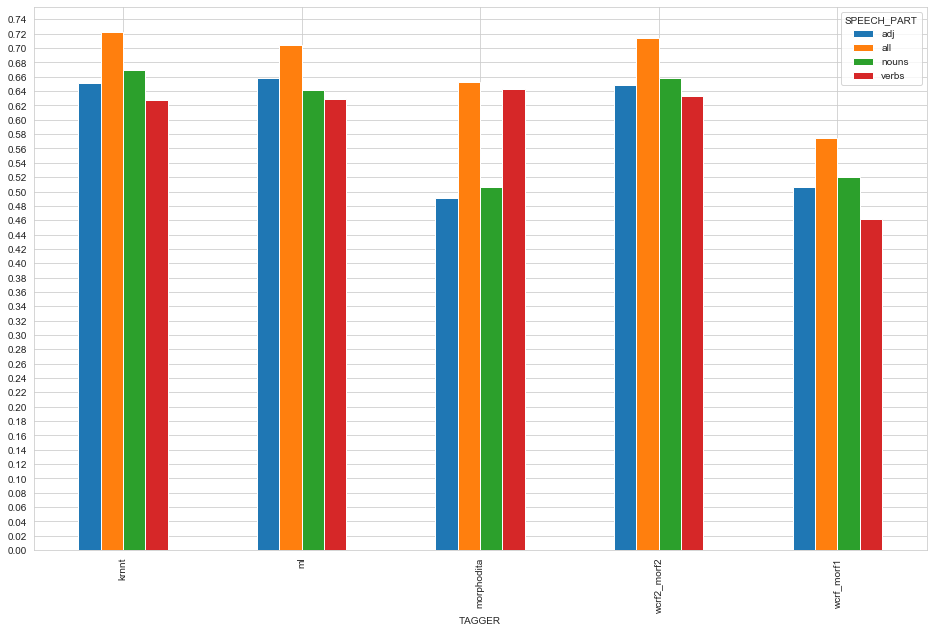

In [195]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax.set_ylim(bottom=50,top=75)
stats.groupby(['TAGGER','SPEECH_PART']).max()['ACC'].unstack().plot.bar(ax=ax)

    Krnnt najlepiej radzi sobie z rzeczownikami,
    ml - z przymiotniami
    morphodita - z czasowniami 
    wcrf2_morf2 - z rzeczownikami 
    wcrf_morf1 - z rzeczownikami. 

#### Wpływ stostunku podziału wzorców uczących na zbióry treningowe i testowe 

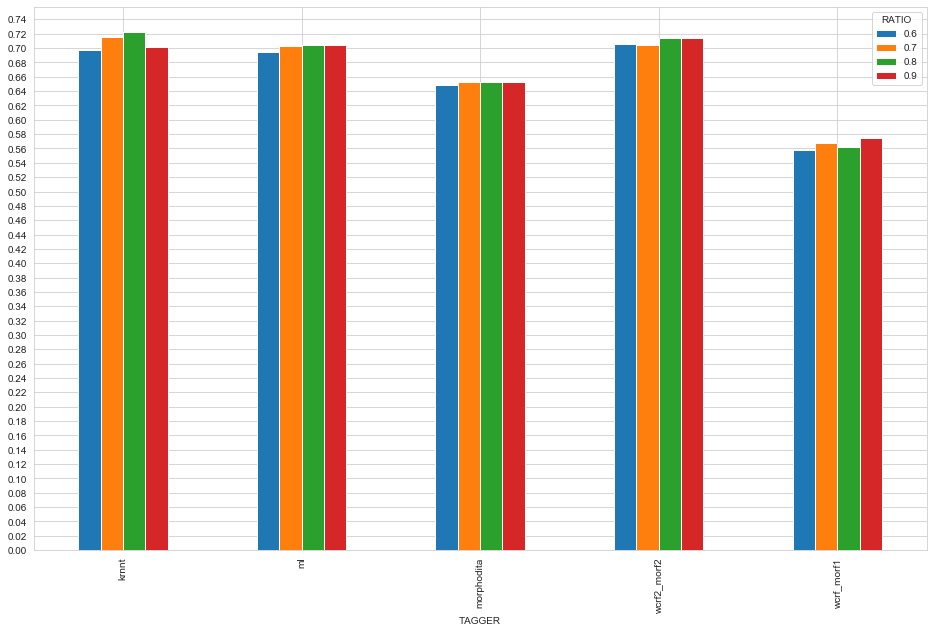

In [203]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax.set_ylim(bottom=50,top=75)
stats.groupby(['TAGGER','RATIO']).max()['ACC'].unstack().plot.bar(ax=ax)

W zalezności od taggera, najelpsze stostunki podziału zbioru wzorców uczących były różne. 

#### Wpływ metdy klasyfikacji na średnie osiągi taggera

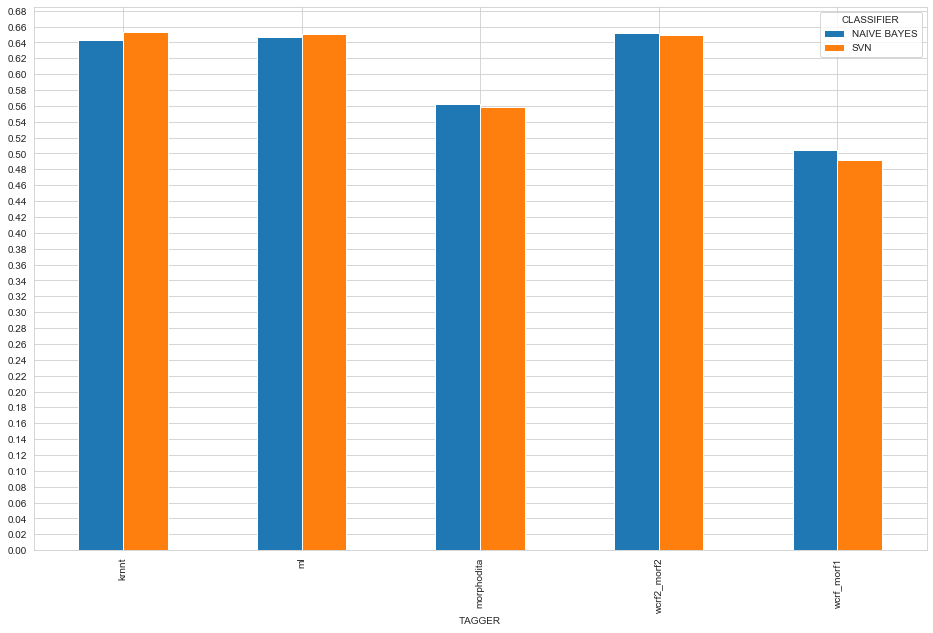

In [6]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax.set_ylim(bottom=50,top=75)
stats.groupby(['TAGGER','CLASSIFIER']).mean()['ACC'].unstack().plot.bar(ax=ax)

Średnio dla krnnt i ml SVN radził sobie lepiej. W pozotałych prypadkach to Naive Bayes dawał lepsze wyniki.

#### Wpływ metdy klasyfikacji na maksymalne osiągi taggera

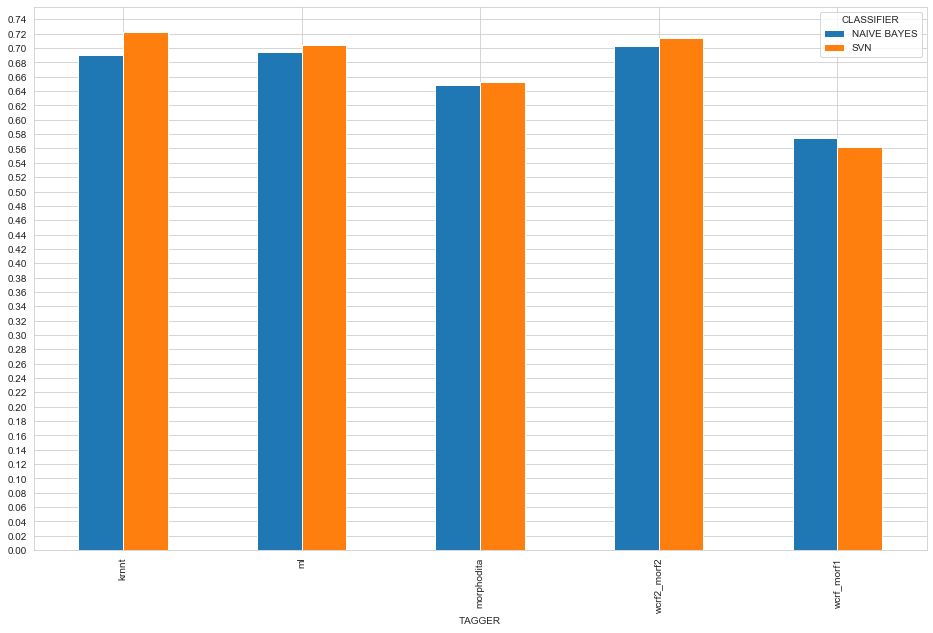

In [205]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax.set_ylim(bottom=50,top=75)
stats.groupby(['TAGGER','CLASSIFIER']).max()['ACC'].unstack().plot.bar(ax=ax)

Z wyjątkiem taggera działającego w oparciu o morfeusza1, najlepsze wyniki globalnie uzyskiwał klasyfikator SVN. 

#### Wpływ doboru klasyfikatora na wyniki klasyfikacji części mowy

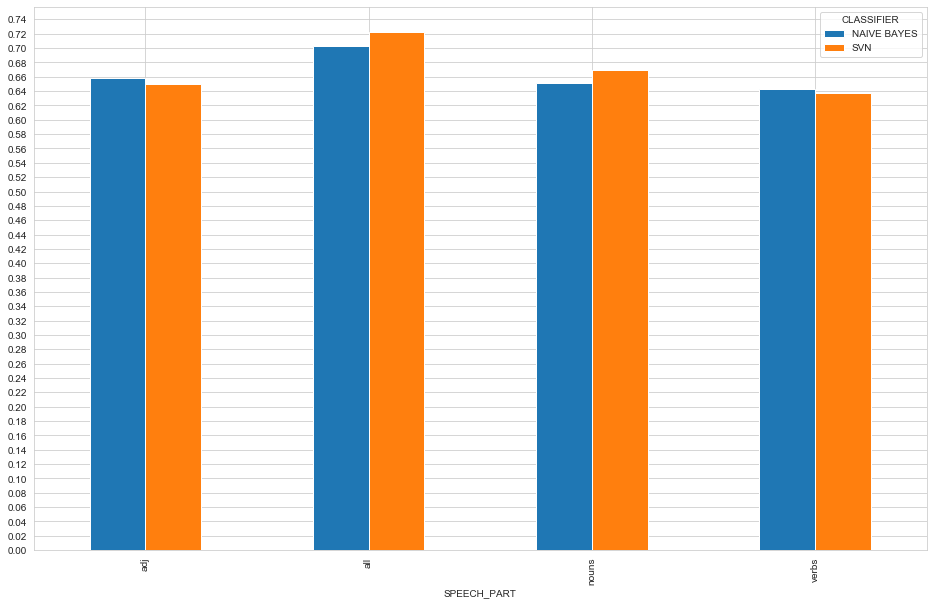

In [206]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax.set_ylim(bottom=50,top=75)
stats.groupby(['SPEECH_PART','CLASSIFIER']).max()['ACC'].unstack().plot.bar(ax=ax)

Do klsayfikacji przymiotników i czasowników najlepiej wykorzystywać klasyfikator Bayesowski, a do klasyfikacji reczowników i w oparciu o wszystkie części mowy - klasyfikator SVN.

### Macierz pomyłek dla przykładowego modelu

In [199]:
X_train,X_train_tf,X_train_tfidf,Y_train,X_test,X_test_tf,X_test_tfidf,Y_test=prepare_data('krnnt','verbs',0.8)

In [200]:
model_best=SVN_classifier(X_train,Y_train)[0]

In [201]:
predicted_labels=model_best.predict(X_test)

[[505   1 117   1   2  14]
 [ 58   0  14   2   2   6]
 [110   2 407   3   1  21]
 [ 81   1  95   7   3   8]
 [ 82   0  57   2   0  10]
 [ 24   0  11   0   0 218]]


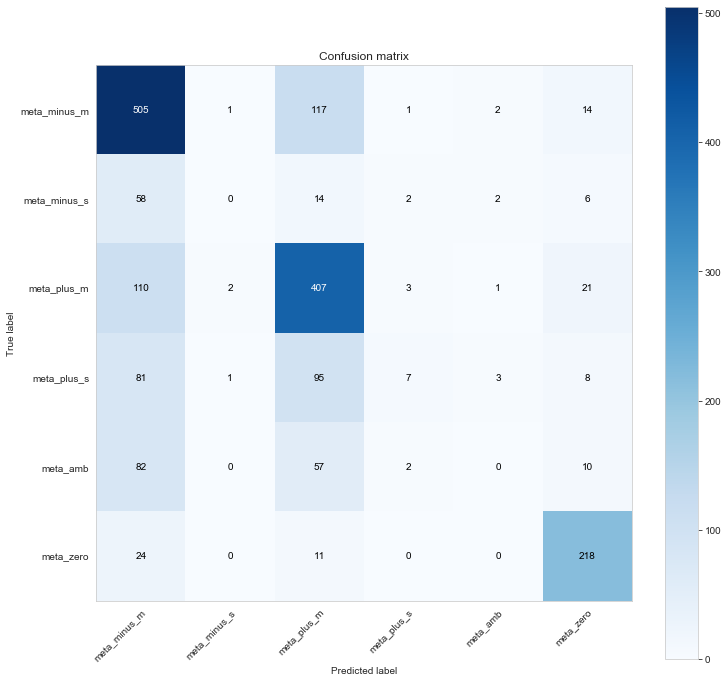

In [208]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

visualize_confusion_matrix(Y_test, predicted_labels, classes=LABELS,
                      title='Confusion matrix')

### Wniosek:

Klasyfikator z dużą skutecznoiścią predykuje klasy meta_minus_m i meta_plus_m oraz meta_zero. Natomias słabo radzi sobie z kalsami meta_minus_s, meta_plus_s oraz meta_amb. Może mieć to jedank związek z małą liczbą wzorców z takimi etykietami w zbiorze danych. Można by podjąć próbę poprawy jakości klasyfilkacji poprzez zasosowanie podziału stratyfikowanego.